# Data Based Wetsuit Buying Guide
> A wetsuit buying guide for Dutch surfers, according to historical surf forecasts and wetsuit recommnedations on [surfweer](surfweer.nl)

- toc: false
- badges: true
- comments: true
- categories: [data analysis, surfing, jupternotebook]

In [346]:
# hide
copy_to_post = 1  # if true, copied to the blog post git folder

In [347]:
# hide
from pathlib import Path

import calplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colors

# sns.color_palette("Blues_d")

In [348]:
# hide
def report_na(df, col):

    print(
        "{:0.2f}% rows do not contain {:} recommendation".format(
            100 * df[col].isna().mean(), col
        )
    )

# Introduction

I got the surfing bug during a vacation in Portugal and has been an weekend warrior in Scheveningen ever since. In contrast to the warm and pleasant subtropical conditions in Protugal, the Dutch surf scene is quite different characterized by wind and rains. As one who surfs only during the weekends, I am truely grateful that my wetsuits allowes surf til fatigue without worrying about being cold. 

Recently, I decided to invest in some quality wetsuits, in order to surf all year round. As an engineer who always rely on data to make decisions, I started this project to analyze the surf reports posted on [surfweer](https://surfweer.nl). Most of the forecasts contain a section on wetsuit recommendations that forms the input of my project. 

After [web crawling and data cleaning](https://github.com/jinchao-chen/surf_report_analysis), I was able to gather a few entires that covers the period from 2019 to 2020. With these available information, I would like to get to know:

- How often is there a surfable condition? 
- What types of wetsuit do I need to surf in different seasons?

In [349]:
# hide

fln = "surfweer_data_2021_02_15_clean.csv"

df = pd.read_csv(
    fln,
    index_col=0,
    parse_dates=["report_date", "post_date"],
    dtype={"wetsuit": "str", "schoen": "str", "cap": "str"},
)
df["week"] = df["report_date"].apply(lambda x: x.isocalendar()[1])
df["weekday"] = df["report_date"].apply(lambda x: x.weekday())

In [350]:
# hide

a = [2019, 2020]
df = df[df["year"].isin(a)].copy()

# Monthly Surf Days 

In [351]:
# hide
df["test"] = 1
df_sub = df[["report_date", "test"]]
df_sub = df_sub.drop_duplicates()

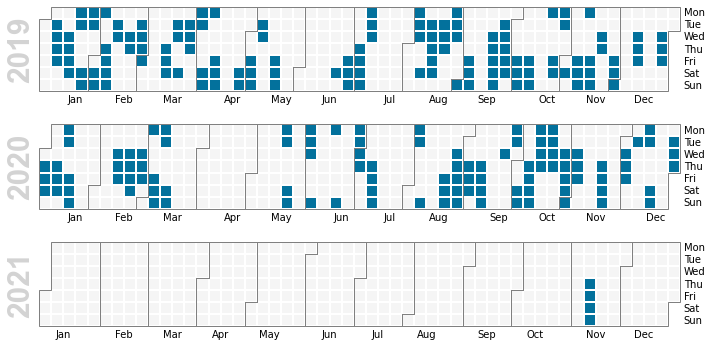

In [352]:
# hide
events = pd.Series(df_sub["test"].to_numpy(), index=df_sub["report_date"])
cmap = colors.ListedColormap(["xkcd:ocean blue", "green"])
calplot.calplot(events, cmap=cmap);

In [353]:
# hide
df_monthly = df.groupby(["year", "month"])["report_date"].count()
df_monthly = df_monthly.reset_index()

The data contains . 

Observations: 

- swells are mostly active in spring and autumn. the frequency peaks in 
- camel peaks distribution  

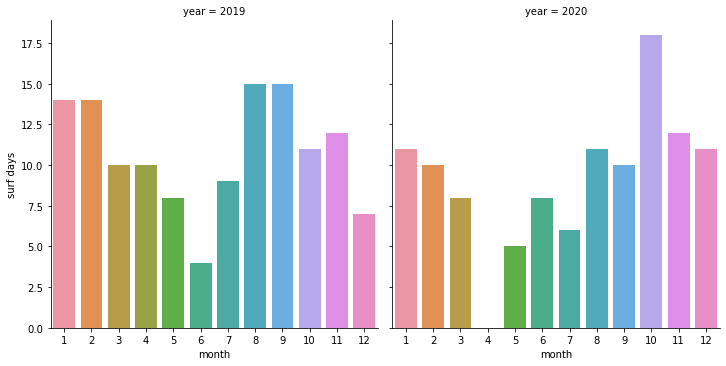

In [354]:
# hide_input
ax = sns.catplot(
    x="month",
    y="report_date",
    col="year",
    data=df_monthly,
    kind="bar",
    #     palette=("Blues_d"),
)
ax.set_ylabels("surf days");

# Wetsuit Recommendations

As per [srface](https://srface.com/knowledge-base/neoprene-wetsuit-thickness/), *brands usually advertise their wetsuit neoprene thicknesses as 3/2, 4/3, 5/4, 6/4, etc. 3/2 for instance, means this wetsuit’s main panels are 3mm and 2mm thick. Normally, the chest and back panels are made out of thicker neoprene foam for extra warmth. Arms, shoulders, and legs are usually thinner for more flexibility.* 

I chose to use the main panel thickness only in the analysis, to reduce the number of types. It will be renamed using 3, 4, 5, 6. 

In [355]:
# hide
def rename_wetsuit(wet_suit):
    """
    Rename wetsuit, use only the main panel thickenss (the first character in the string)
    """
    try:
        return wet_suit[0]
    except:
        pass

In [356]:
# hide
df["wetsuit"] = df["wetsuit"].apply(rename_wetsuit)

In [357]:
# hide
def sort_hue(values):
    """sort string list
    """
    values.sort(key=float)
    return values


def monthly_summary(df, item):

    # Create monthly summary
    monthly = df.groupby(["month", item])["report_date"].count()
    monthly = monthly.reset_index()
    values = list(monthly[item].unique())

    # plot
    ax = sns.histplot(
        x="month",
        weights="report_date",
        hue=item,
        data=monthly,
        multiple="stack",
        bins=12,
        discrete=True,
        hue_order=sort_hue(values),
        shrink=0.8,
    )

    ax.set_xlabel("month")
    ax.set_ylabel("days")
    ax.set_xticks(np.arange(1, 12 + 1, 1.0))
    ax.set_xticklabels(
        [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
    )

    labels = ["{:} mm".format(value) for value in sort_hue(values)]
    ax.legend(
        title=item, labels=labels[::-1],
    )

    return ax

## Wetsuit

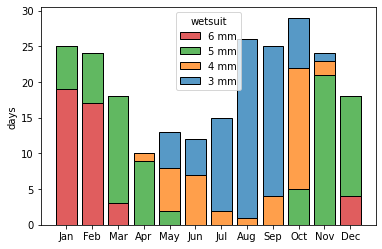

In [358]:
# hide_input

# correct some abnoral values
df.loc[df["wetsuit"] == "8", "wetsuit"] = "6"
df.loc[df["wetsuit"] == "8", "schoen"] = "8"
df.loc[(df["wetsuit"] == "4") & (df["month"] == 2), "wetsuit"] = "5"

# fill na (it contains approxiamte 25% na )
df["wetsuit"] = df["wetsuit"].fillna(method="backfill")

# report_na(df, "wetsuit");

ax = monthly_summary(df, "wetsuit")
ax.set_xlabel("")
fig = ax.figure

In [359]:
# hide
monthly = df.groupby(["wetsuit"])["report_date"].count()
monthly = monthly.reset_index()

In [360]:
# monthly['wetsuit'] = monthly['wetsuit'].astype(int)

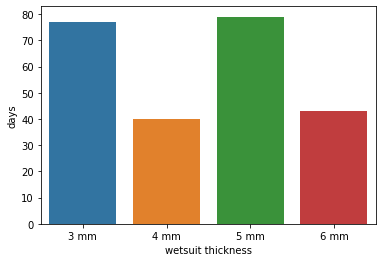

In [361]:
# hid_input
ax = sns.barplot(x="wetsuit", y="report_date", data=monthly,)
ax.set_xlabel("wetsuit thickness")
ax.set_ylabel("days")
ax.set_xticklabels(["3 mm", "4 mm", "5 mm", "6 mm"]);

In [362]:
# hide_input
bars = (
    alt.Chart(monthly)
    .mark_bar()
    .encode(
        x=alt.X("sum(report_date):Q", stack="zero"),
        #             y='y:N',
        color=alt.Color("wetsuit:N"),
        order="wetsuit:N",
    )
)
text = (
    alt.Chart(monthly)
    .mark_text(dx=-15, dy=-2, color="white")
    .encode(
        x=alt.X("sum(report_date):Q", stack="zero"),
        detail="wetsuit:Q",
        text=alt.Text("report_date:O"),
        order="wetsuit:N",
    )
)
bars + text

alt.LayerChart(...)

In [363]:
# hide_input 
import altair as alt
monthly = df.groupby(["month", "wetsuit"])["report_date"].count()
monthly = monthly.reset_index()
monthly["month"] = monthly["month"].astype("str")
monthly["month"] = monthly.month.str.zfill(2)
base = (
    alt.Chart(monthly)
    .mark_bar()
    .encode(
        x=alt.X(
            "month:N",
            sort=alt.SortField(field="month", order="ascending"),
            axis=alt.Axis(title="month"),
        ),
        y=alt.Y("sum(report_date)", axis=alt.Axis(title="surf days")),
    )
    .properties(width=alt.Step(80))  # controls width of bar.
    .configure_mark(opacity=0.1, color="grey")
)
base

alt.Chart(...)

In [364]:
# hide_input
import altair as alt
from vega_datasets import data

select_box = alt.binding_select(options=list(monthly["wetsuit"].unique()))
selection = alt.selection_single(
    name="thickness of", fields=["wetsuit"], bind=select_box, init={"wetsuit": "3"}
)

base = (
    alt.Chart(monthly)
    .mark_bar(opacity=0.1, color="grey")
    .encode(
        x=alt.X(
            "month:N",
            sort=alt.SortField(field="month", order="ascending"),
            axis=alt.Axis(title="month"),
        ),
        y=alt.Y("sum(report_date)", axis=alt.Axis(title="surf days")),
    )
    .properties(width=alt.Step(80))  # controls width of bar.
)

alt.layer(
    base,
    alt.Chart(monthly)
    .mark_bar(opacity=0.4, color="red")
    .encode(
        x=alt.X(
            "month:N",
            sort=alt.SortField(field="month", order="ascending"),
            axis=alt.Axis(title="month"),
        ),
        y=alt.Y("sum(report_date)", axis=alt.Axis(title="surf days")),
        tooltip="wetsuit",
    )
    .add_selection(selection)
    .transform_filter(selection),
)

alt.LayerChart(...)

## Schoen

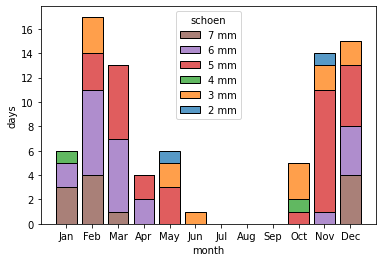

In [365]:
# hide_input
# report_na(df, "schoen")
monthly_summary(df, "schoen");

## **Cap**

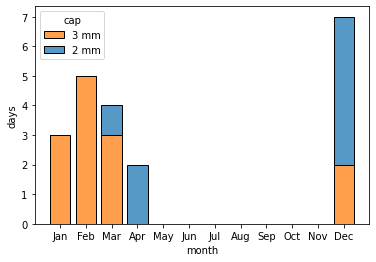

In [366]:
# hide_input
# report_na(df, "cap")
monthly_summary(df, "cap");

In [367]:
# hide

from shutil import copyfile

if copy_to_post:
    src = "data_visualization.ipynb"
    dst = "../blog_posts/_notebooks/2021-02-14-wetsuit-guide.ipynb"
    copyfile(src, dst)

    print("copied")

copied
